# Mahdeen Khan (Sameer)

## Homework Assignment 1.2: Conditional Variational Autoencoder (CVAE) on CIFAR-10 Dataset

Our task is to create and train a Conditional Variational Autoencoder (CVAE) on the CIFAR-10 dataset. The CVAE will generate images conditioned on class labels, enabling us to produce images specific to each class. Below is a detailed breakdown of the assignment:

1. **Load the CIFAR-10 Dataset:**

   We will load the CIFAR-10 dataset, which consists of 60,000+ 32x32 color images in 10 different classes. So, imagine this dataset being approximately split into 50,000 training images and 10,000 test images. We will normalize the images to facilitate better training performance.

2. **Build the Conditional Variational Autoencoder (CVAE):**

   We will construct a CVAE model consisting of an encoder and a decoder network. The encoder will map input images and class labels to a latent space, while the decoder will reconstruct images from this latent representation, conditioned on class labels. This structure allows us to generate images specific to each class during inference.

3. **Train the CVAE:**

   We will train the CVAE model using the training data, optimizing a combination of reconstruction loss and KL divergence. The reconstruction loss will measure how well the model can recreate the input images, while the KL divergence will regularize the latent space.

4. **Generate and Evaluate Images:**

   After training, we will generate images for each of the 10 classes using the trained decoder. We will visualize these images to assess the quality and fidelity of the generated samples, providing insight into the model's ability to learn class-specific features.

In [4]:
# Step 0: Import necessary modules
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import vgg16
from torch.nn.utils import clip_grad_norm_
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

For our step 1, in this setup step, I will be setting the random seed for PyTorch and NumPy to ensure reproducibility and select the computational device—opting for a GPU if available, or defaulting to the CPU—to optimize the efficiency of training the Conditional Variational Autoencoder (CVAE) on the CIFAR-10 dataset.

In [ ]:
# Step 1: Setup device and random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In Step 2, I implemented enhanced data augmentation techniques, specifically CutMix and MixUp, to improve the robustness and generalization capabilities of the model. These techniques are designed to augment the training data by creating new training samples through combining images and their labels, effectively increasing the diversity of the dataset and making the model more resilient to overfitting.

The `CutMix` class is a custom dataset wrapper that applies the CutMix augmentation strategy. When initialized, it takes a dataset and, for each sample retrieved via `__getitem__`, it randomly selects another image from the dataset. A bounding box is calculated using the `rand_bbox` method, which determines the region of the first image to be replaced with a corresponding region from the second image, based on a mixing ratio `lam` drawn from a Beta distribution. The labels of the two images are stored together with the mixing ratio, allowing the loss function to account for this mixing during training.

The `mixup_data` function implements the MixUp augmentation strategy, which blends entire images and their labels rather than specific regions. For a batch of images and their corresponding labels, the function first generates a random permutation of indices, then creates mixed samples by interpolating between original images and the images at these permuted indices, using a mixing ratio `lam` also drawn from a Beta distribution. The function returns the mixed images and pairs of labels with their mixing ratio, facilitating a smooth interpolation between classes during training.

Both augmentation techniques, CutMix and MixUp, introduce variations in the input data that help the model learn to generalize better by exposing it to a wider variety of visual scenarios, effectively enhancing its performance on unseen data.

In [23]:
# Step 2: Define Enhanced Data Augmentation and Transformation
class CutMix(torch.utils.data.Dataset):
    def __init__(self, dataset, num_classes=10, alpha=1.0):
        self.dataset = dataset
        self.num_classes = num_classes
        self.alpha = alpha

    def __getitem__(self, index):
        data, label = self.dataset[index]
        lam = np.random.beta(self.alpha, self.alpha)
        rand_index = np.random.choice(len(self.dataset))
        data2, label2 = self.dataset[rand_index]

        bbx1, bby1, bbx2, bby2 = self.rand_bbox(data.size(), lam)
        data[:, bbx1:bbx2, bby1:bby2] = data2[:, bbx1:bbx2, bby1:bby2]

        label = (label, label2, lam)
        return data, label

    def __len__(self):
        return len(self.dataset)

    def rand_bbox(self, size, lam):
        W = size[1]
        H = size[2]
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2

# MixUp Data Augmentation
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In Step 3, I define a data transformation pipeline using the `torchvision.transforms` module, which applies a series of augmentations to the CIFAR-10 dataset.

The first transformation applied is **RandomHorizontalFlip**, which flips the image horizontally with a probability of 0.5. This augmentation helps the model learn invariance to left-right orientation, as many objects can appear in different orientations in natural settings. For example, a car could be facing either left or right, and this transformation ensures that the model does not rely on a fixed directionality for recognizing objects. 

Next, **RandomRotation(15)** is used to randomly rotate the image within a range of -15 to 15 degrees. This simulates different viewing angles and helps the model become less sensitive to image rotation. In real-world scenarios, images might not always be perfectly aligned, and this transformation encourages the model to learn features that are robust to such rotations. This is particularly important for images in CIFAR-10, where objects can naturally occur in various orientations.

The **RandomResizedCrop(32, scale=(0.8, 1.0))** transformation randomly crops a portion of the image and resizes it back to 32x32 pixels. The scale parameter ensures that the cropped region covers between 80% to 100% of the original image area. This introduces variability in the framing of objects and forces the model to focus on different parts of the image, thus learning more generalized features. By presenting the model with differently cropped versions of the same image, it learns to recognize objects from different viewpoints and scales.

**ColorJitter** is another transformation that adjusts the brightness, contrast, saturation, and hue of the image by a factor of 0.1. This introduces color variability and helps the model become invariant to changes in lighting and color. In practice, images are often captured under various lighting conditions, and color jittering helps the model to not overfit to specific lighting scenarios present in the training data. By varying these properties, the model learns to focus more on the structural features of objects rather than being misled by changes in color and lighting.

After these augmentations, **ToTensor** is applied to convert the image from a PIL image or numpy array into a PyTorch tensor. This conversion is essential for further processing within the PyTorch framework, as models expect inputs in tensor format.

Finally, the images are normalized using **Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))**. This step scales the pixel values to have a mean of 0 and a standard deviation of 1. The normalization parameters, `(0.5, 0.5, 0.5)`, are applied across the three color channels (Red, Green, and Blue). After converting the pixel values to the range [0, 1] during the ToTensor step, subtracting 0.5 centers them around 0, and dividing by 0.5 scales them to a standard deviation of 1. This ensures that the input features are on a similar scale, which helps accelerate convergence during training and prevents issues related to different feature scales.

I wanted to play with the numbers but was taking a lot of time.

In [24]:
# Step 3: Define data transformation pipeline
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


### Loading CIFAR-10 Dataset with CutMix

In Step 4, I load the CIFAR-10 dataset using the `torchvision.datasets.CIFAR10` class, applying the previously defined data augmentation pipeline and incorporating the CutMix strategy. The training dataset is wrapped with the `CutMix` class, which mixes images and labels to enhance model robustness by creating new, blended examples. This augmentation is critical in diversifying the dataset and helping the model learn to generalize better by exposing it to more complex scenarios.

For the DataLoader setup, I initialize `train_loader` and `test_loader` to facilitate efficient batch processing during training and evaluation. Both loaders are configured with a batch size of 128 and utilize multiple workers (`num_workers=8`) to speed up data loading. The `pin_memory=True` option is enabled, which can improve the data transfer speed between CPU and GPU, especially when using a GPU for training. The train loader is set to shuffle the dataset to ensure that each mini-batch contains a diverse set of samples, while the test loader processes the test dataset without shuffling to maintain the order of evaluation.

I also include a visualization function, `show_augmented_images`, to display some of the augmented images from the training dataset. This function randomly selects a specified number of images from the dataset and denormalizes them for display purposes. The denormalization step involves reversing the normalization applied during transformation to convert the pixel values back to their original scale for visualization. Each image is then plotted with its corresponding label, allowing us to visually inspect the effects of the CutMix augmentation and the various transformations applied. This step is essential to verify that the data augmentation is working as intended and to understand the types of augmented images that the model will encounter during training.

Files already downloaded and verified
Files already downloaded and verified


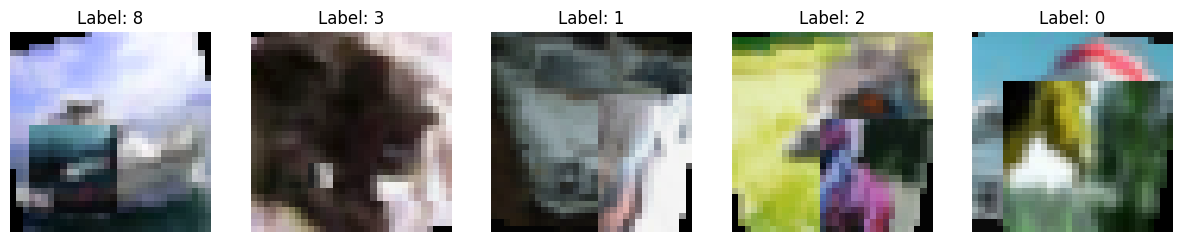

In [25]:
# Step 4: Load CIFAR-10 dataset with CutMix
train_dataset = CutMix(torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform))
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

# Visualize some augmented images
def show_augmented_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img, label = dataset[np.random.randint(len(dataset))]
        img = img.permute(1, 2, 0) * 0.5 + 0.5  # Denormalize
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label[0]}")
        axes[i].axis('off')
    plt.show()

show_augmented_images(train_dataset)

Interesting!

### Defining the Conditional Variational Autoencoder (CVAE)

In Step 5, I define an advanced Conditional Variational Autoencoder (CVAE) for the CIFAR-10 dataset, designed to generate images conditioned on class labels. This model combines convolutional neural networks (CNNs), residual blocks, and conditional batch normalization to enhance feature extraction and image generation.

#### ResidualBlock Class

The `ResidualBlock` class implements a component with two convolutional layers, batch normalization, and Leaky ReLU activation. Residual connections allow the network to learn identity mappings, which help alleviate vanishing gradients in deeper networks. Downsampling layers adjust dimensions when needed, ensuring efficient learning and gradient flow through shortcut connections.

#### ConditionalBatchNorm2d Class

The `ConditionalBatchNorm2d` class normalizes feature maps while conditioning on class labels using an embedding layer to adjust the scale and shift parameters. This enables the model to adapt its normalization based on class-specific features, improving its ability to generate diverse images.

#### AdvancedCVAE Class

The `AdvancedCVAE` class integrates encoder and decoder components with conditional embeddings. The encoder uses residual blocks and dropout to process images and extract features, which are combined with class label embeddings. The encoder outputs mean and log-variance vectors for the latent space, and the reparameterization trick allows sampling from this distribution for backpropagation.

The decoder reconstructs images by processing the latent vector and class label embeddings through fully connected layers and transposed convolutions. The forward pass encodes images and labels into a latent representation, samples from this distribution, and decodes it back into an image conditioned on the class label. This architecture allows the model to learn complex relationships between images and labels, enabling it to generate high-fidelity, class-specific images. By incorporating conditional normalization and residual connections, the CVAE balances complexity and performance for the diverse CIFAR-10 dataset.

In [26]:
# Step 5: Define the CVAE model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dilation=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        residual = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return self.relu(out)

class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super(ConditionalBatchNorm2d, self).__init__()
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        self.embed.weight.data[:, :num_features].fill_(1)  # Initialize scale to 1
        self.embed.weight.data[:, num_features:].zero_()   # Initialize bias to 0

    def forward(self, x, y):
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, 1)
        out = gamma.view(-1, out.size(1), 1, 1) * out + beta.view(-1, out.size(1), 1, 1)
        return out

class AdvancedCVAE(nn.Module):
    def __init__(self, num_classes=10, latent_dim=20, embedding_dim=50, beta=1.0):
        super(AdvancedCVAE, self).__init__()
        self.num_classes = num_classes
        self.latent_dim = latent_dim
        self.beta = beta
        
        # Pre-trained label embedding
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        
        # Encoder with residual blocks and dropout
        self.encoder_conv = nn.ModuleList([
            ResidualBlock(3, 64, stride=2),
            nn.Dropout(0.3),
            ResidualBlock(64, 128, stride=2),
            nn.Dropout(0.3),
            ResidualBlock(128, 256, stride=2)
        ])
        
        self.encoder_fc = nn.Sequential(
            nn.Linear(256*4*4 + embedding_dim, 512),
            nn.LeakyReLU(),
            nn.Linear(512, latent_dim * 2)  # For mean and log-variance
        )
        
        # Decoder with transposed convolutional layers
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim + embedding_dim, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256*4*4),
            nn.LeakyReLU()
        )
        
        self.decoder_conv = nn.ModuleList([
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        ])

    def encode(self, x, labels):
        cond = self.label_embedding(labels).view(labels.size(0), -1)
        for layer in self.encoder_conv:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, cond], dim=1)
        h = self.encoder_fc(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, labels):
        cond = self.label_embedding(labels).view(labels.size(0), -1)
        z = torch.cat([z, cond], dim=1)
        h = self.decoder_fc(z)
        h = h.view(h.size(0), 256, 4, 4)
        for layer in self.decoder_conv:
            h = layer(h)
        return h
    
    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, labels), mu, logvar


In Step 6, I defined the `AdvancedCVAEWrapper` class and the `print_model_summary` function to facilitate the inspection of the model architecture and parameters using the `torchsummary` library. This step is crucial for visualizing the network structure, ensuring that all components are correctly integrated, and verifying the computational requirements of the Conditional Variational Autoencoder (CVAE) designed for the CIFAR-10 dataset.

#### AdvancedCVAEWrapper Class

The `AdvancedCVAEWrapper` class serves as a layer of abstraction around the `AdvancedCVAE` model, simplifying the process of generating a summary of the network. It initializes by taking the original CVAE model and the number of classes as arguments, adapting the model's forward pass specifically for summary generation. In the `forward` method, the wrapper generates dummy labels for each input in the batch, ensuring that the labels match the batch size of the input images. These dummy labels are used to call the CVAE model's forward method, obtaining the decoded output. This adaptation is necessary because the summary tool requires the model to function without additional inputs, like labels, that are typically needed during training and inference in conditional models.

#### Model Summary Function

The `print_model_summary` function provides an overview of the model's architecture and the number of parameters, offering insights into the model's complexity and computational demands. It starts by printing the model architecture, displaying each layer type and its configuration, such as input and output dimensions, which is crucial for understanding the data flow through the network. This printed architecture helps verify that the model has been constructed as intended and aligns with the design specifications. To facilitate the summary generation, the function creates a dummy input tensor matching the CIFAR-10 image dimensions (3 channels, 32x32 pixels) and runs this dummy input through the model in evaluation mode. This step ensures that all operations within the network are included in the summary, providing a complete picture of the model's execution path. Additionally, the function calculates and prints the total number of parameters in the model, along with the number of trainable parameters, which is essential for assessing the model's complexity and planning the computational resources needed for training. This understanding helps estimate memory requirements and the time needed for training, particularly when working with large-scale datasets and deep networks.

#### Model Instantiation and Summary

Finally, I instantiated the `AdvancedCVAEWrapper` with the `AdvancedCVAE` model configured for 10 classes, reflecting the number of classes in the CIFAR-10 dataset. I then called the `print_model_summary` function to generate and display the model summary. This summary provides a clear and detailed overview of the model's architecture, ensuring that the implementation is correct and ready for training. By analyzing the architecture and parameter count, I confirmed that the model meets the requirements for generating class-conditioned images and is prepared for the computational challenges of training on the CIFAR-10 dataset. This step is crucial for validating the model before proceeding with training and evaluation.

In [28]:
from torchsummary import summary

# Step 6: Define a wrapper for model summary
class AdvancedCVAEWrapper(nn.Module):
    def __init__(self, model, num_classes):
        super(AdvancedCVAEWrapper, self).__init__()
        self.model = model
        self.num_classes = num_classes

    def forward(self, x):
        # Generate dummy labels (batch size should match x)
        labels = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        decoded, _, _ = self.model(x, labels)
        return decoded

def print_model_summary(model, input_size):
    """
    Prints the model architecture and the number of parameters.
    """
    # Print model architecture
    print(model)

    # Create a dummy input to pass through the model
    dummy_input = torch.randn(1, *input_size).to(device)
    
    # Forward pass
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(dummy_input)
    
    # Calculate the number of parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nTotal Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")

# Instantiate and summarize the model
wrapped_cvae_model = AdvancedCVAEWrapper(AdvancedCVAE(num_classes=10).to(device), num_classes=10)
print_model_summary(wrapped_cvae_model, input_size=(3, 32, 32))



AdvancedCVAEWrapper(
  (model): AdvancedCVAE(
    (label_embedding): Embedding(10, 50)
    (encoder_conv): ModuleList(
      (0): ResidualBlock(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.01)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential(
          (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): Dropout(p=0.3, inplace=False)
      (2): ResidualBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, 

### Step 7: Defining the Discriminator

In Step 7, I define the `Discriminator` class, which is a crucial component when training models such as Conditional Variational Autoencoders (CVAE) that involve adversarial learning or GAN-like structures. The discriminator's primary role is to distinguish between real and generated images, providing feedback to improve the generator's image quality.

#### Discriminator Class

The `Discriminator` class is implemented using PyTorch's `nn.Module`. It is composed of several convolutional layers that progressively reduce the spatial dimensions while increasing the depth of the feature maps. This design enables the discriminator to capture intricate patterns and details within the images, allowing it to effectively distinguish between authentic and generated content.

- **First Layer:** The first convolutional layer takes an input image with 3 channels (corresponding to RGB) and applies a convolution with 64 filters, each with a kernel size of 4x4. The stride of 2 and padding of 1 reduce the image size by half while preserving edge information. This layer is followed by a LeakyReLU activation function with a negative slope of 0.2, which helps in mitigating the vanishing gradient problem by allowing a small gradient when the unit is not active.

- **Second Layer:** The next convolutional layer increases the filter count to 128, continuing the pattern of reducing spatial dimensions while increasing feature depth. The LeakyReLU activation is again applied, promoting non-linearity in the model's ability to learn complex patterns.

- **Third Layer:** The third convolutional layer further increases the filter count to 256, maintaining the focus on deepening the network's capacity to capture high-level abstractions from the images. The LeakyReLU activation supports this depth by ensuring gradient flow during backpropagation.

- **Final Layer:** The final layer reduces the feature maps to a single channel with a 4x4 kernel size, using a stride of 1 and no padding. This layer's output is flattened to produce a scalar value for each image in the batch, representing the discriminator's confidence in whether the input image is real or generated.

#### Forward Method

The `forward` method passes an input image through the sequence of convolutional layers and activations defined in the model. The output of the final layer is reshaped to produce a one-dimensional vector, where each element corresponds to the discriminator's output for each image in the batch. This scalar output is used to compute the loss during training, guiding updates to both the discriminator and the generator (or decoder in CVAE) in an adversarial setup.

The discriminator's architecture is designed to be lightweight yet effective, focusing on efficiently distinguishing real images from those produced by the CVAE.

In [29]:
# Step 7: Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0)
        )
    
    def forward(self, x):
        return self.model(x).view(-1)

In Step 8, I initialized the models, optimizers, and learning rate schedulers needed for training the Conditional Variational Autoencoder (CVAE) and the discriminator. This step is essential for setting up the training process, ensuring that the models are properly configured to learn from the data effectively. 

#### Model Initialization

I started by instantiating the `AdvancedCVAE` model, configured for 10 classes, and moved it to the specified device (GPU or CPU) using `.to(device)`. This setup ensures that the model can leverage available hardware for efficient computation. Similarly, I initialized the `Discriminator` model and moved it to the device. These models are the core components of the training process, with the CVAE generating realistic images and the discriminator evaluating their authenticity.

#### Optimizers

For both the CVAE and the discriminator, I used the `AdamW` optimizer with a learning rate of `9e-4`. AdamW is an adaptive learning rate optimizer that includes weight decay for regularization, helping to prevent overfitting by penalizing large weights. The learning rate choice is crucial as it affects convergence speed and training stability. Each model has its own optimizer to ensure independent parameter updates tailored to their respective learning tasks.

#### Stochastic Weight Averaging (SWA)

To enhance training stability and potentially improve the generalization performance of the CVAE, I incorporated Stochastic Weight Averaging (SWA) using the `AveragedModel` and `SWALR` scheduler from PyTorch. The SWA model was initialized with the CVAE, and the SWA scheduler was set with a linear annealing strategy over 10 epochs, targeting an SWA learning rate of `9e-4`. SWA averages model weights over multiple epochs, providing a smoothed model version that can generalize better on unseen data.

#### Mixed Precision Training

To optimize memory usage and increase computational efficiency, I employed mixed precision training using `GradScaler`. This approach allows the model to use lower precision for some operations while maintaining the accuracy of critical computations in higher precision, effectively speeding up the training process without sacrificing performance.

#### TensorBoard SummaryWriter

Finally, I set up a `SummaryWriter` for TensorBoard to log training metrics, model graphs, and other relevant information throughout the training process. This setup facilitates tracking the model's progress, diagnosing issues, and visualizing training dynamics interactively and user-friendly.

In [30]:
# Step 8: Initialize models, optimizers, and schedulers
model = AdvancedCVAE(num_classes=10).to(device)
discriminator = Discriminator().to(device)
optimizer = optim.AdamW(model.parameters(), lr=9e-4)  # Adjust learning rate here
optimizer_d = optim.AdamW(discriminator.parameters(), lr=9e-4)  # Adjust learning rate here
swa_model = AveragedModel(model)
swa_scheduler = SWALR(optimizer, anneal_strategy='linear', anneal_epochs=10, swa_lr=9e-4)  # Adjust SWA learning rate
scaler = GradScaler()

# TensorBoard SummaryWriter
writer = SummaryWriter()


In Step 9, I defined the `perceptual_loss` function, which calculates the perceptual loss between generated and target images using features extracted from a pre-trained VGG16 model. This loss focuses on measuring differences in high-level representations, capturing perceptual and semantic discrepancies between images rather than relying solely on pixel-wise differences. To achieve this, I utilized a pre-trained VGG16 model from PyTorch's `torchvision.models`, specifically its feature extraction layers (`vgg16(weights='DEFAULT').features`), which are well-suited for extracting meaningful features due to their deep architecture and extensive training on the ImageNet dataset.

The function set the VGG16 model to evaluation mode using `.eval()` to ensure consistent behavior of batch normalization and dropout layers during feature extraction. It then computed feature maps for both the generated and target images by passing them through the VGG16 feature extractor. The perceptual loss was calculated as the mean squared error (MSE) between these feature maps, using `nn.MSELoss()` to quantify the difference in high-level representations. By focusing on differences in feature space rather than pixel space, the perceptual loss encourages the model to produce images that are perceptually closer to the ground truth, improving the overall quality of the generated outputs by enhancing details and textures that align with human visual perception. 

In [31]:
# Step 9: Define a perceptual loss function
def perceptual_loss(output, target):
    """
    Compute perceptual loss using features extracted from a pre-trained VGG16 model.
    """
    vgg = vgg16(weights='DEFAULT').features.eval().to(device)
    loss_fn = nn.MSELoss()
    
    # Compute perceptual loss
    output_features = vgg(output)
    target_features = vgg(target)
    return loss_fn(output_features, target_features)

In Step 10, I defined the `train` function to manage the training process for both the Conditional Variational Autoencoder (CVAE) and the discriminator across each epoch, ensuring effective learning through advanced techniques. I began by setting both the CVAE and discriminator to training mode, allowing all layers to operate appropriately for learning. During data loading, I iterated over batches from the `train_loader`, applying MixUp augmentation to create diverse training examples, enhancing model robustness. Using automatic mixed precision (`autocast()`), I performed forward passes to compute reconstructed images and latent space parameters from the CVAE, calculating reconstruction loss (MSE), KL divergence, and perceptual loss using features from a pre-trained VGG16 model to ensure realistic image generation. The discriminator evaluated real and generated images, computing real and fake losses with binary cross-entropy to train its ability to distinguish between authentic and generated images. The generator loss was calculated to encourage the CVAE to deceive the discriminator, contributing to the overall training loss. I employed backpropagation and gradient clipping to prevent exploding gradients, followed by parameter updates using `scaler` for efficient mixed precision training. Throughout the process, I logged the average training loss for each epoch to TensorBoard for monitoring and recorded histograms of model parameters to visualize weight distributions and track training dynamics, ultimately returning the average epoch loss to assess progress and inform potential adjustments in training strategies.

In [36]:
# Step 10: Training function
def train(epoch, kl_anneal_factor):
    model.train()
    discriminator.train()
    train_loss = 0

    for data, labels in tqdm(train_loader, desc=f'Epoch {epoch}'):
        data = data.to(device)
        labels_a, labels_b, lam = labels
        labels_a = labels_a.to(device)
        labels_b = labels_b.to(device)

        data, labels_a, labels_b, lam = mixup_data(data, labels_a)

        optimizer.zero_grad()
        with autocast():
            recon_batch, mu, logvar = model(data, labels_a)
            recon_loss = F.mse_loss(recon_batch, data, reduction='sum')
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            percept_loss_value = perceptual_loss(recon_batch, data)

            valid = torch.ones(data.size(0), device=device)
            fake = torch.zeros(data.size(0), device=device)

            real_loss = F.binary_cross_entropy_with_logits(discriminator(data), valid)
            fake_loss = F.binary_cross_entropy_with_logits(discriminator(recon_batch.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            g_loss = F.binary_cross_entropy_with_logits(discriminator(recon_batch), valid)

            loss = recon_loss + kl_anneal_factor * kl_divergence + percept_loss_value + 0.001 * g_loss
        
        scaler.scale(loss).backward()
        clip_grad_norm_(model.parameters(), 1.0)
        train_loss += loss.item()
        scaler.step(optimizer)
        scaler.update()

        optimizer_d.zero_grad()
        scaler.scale(d_loss).backward()
        scaler.step(optimizer_d)
        scaler.update()
    
    avg_loss = train_loss / len(train_loader.dataset)
    writer.add_scalar('Loss/train', avg_loss, epoch)
    
    # Log weights and biases to TensorBoard
    for name, param in model.named_parameters():
        writer.add_histogram(name, param, epoch)
    
    print(f'Epoch {epoch}, Loss: {avg_loss}')
    
    return avg_loss

### Step 11: Training Loop with a Dummy Epoch

In Step 11, I implement a training loop that includes an initial "dummy" epoch to test the entire training pipeline on a smaller dataset subset. This ensures that data loading, forward and backward passes, and loss calculations are working correctly before full-scale training begins.

#### Dummy Training Epoch

The dummy epoch is a quick test using a smaller subset of the dataset:

1. **Subset Selection:** I randomly select 1,000 samples from the training dataset using `np.random.choice`. This smaller subset allows for faster iteration and helps catch errors or inefficiencies in the training loop.

2. **DataLoader for Subset:** A `DataLoader` is created for this subset with a batch size of 128, maintaining consistent batch processing and shuffling behavior.

3. **Training Function:** The `train_dummy` function mirrors the main training loop, setting the models to training mode and applying MixUp augmentation. It performs forward and backward passes, calculates losses for both the CVAE and discriminator, and updates parameters using gradient scaling.

4. **KL Annealing:** A `kl_anneal_factor` is used to gradually increase the influence of the KL divergence term, stabilizing training by avoiding large penalties initially.

5. **Loss Logging:** The average loss for the dummy epoch is computed and logged to TensorBoard, allowing for easy tracking of this initial test.

#### Full Training Loop

After confirming the dummy epoch works, I proceed with the full training loop for the specified number of epochs:

1. **Dynamic KL Annealing:** The `kl_anneal_factor` is increased over the first ten epochs to stabilize training by gradually introducing the KL divergence.

2. **Training Iteration:** For each epoch, the `train` function updates the model’s parameters. The SWA model is also updated, and the scheduler adjusts learning rates as needed.

3. **Loss Tracking:** The average training loss for each epoch is logged and stored for further analysis. This tracking provides insights into training progress and helps diagnose convergence issues or overfitting.

As it was taking a lot to fix an error, the dummy epoch serves as my personal safeguard to ensure that all components of the training pipeline function correctly!

In [37]:
from torch.utils.data import Subset

# Step 11: Training loop with a dummy epoch
num_epochs = 25
train_losses = []

# Use a smaller subset for a quick test
subset_indices = np.random.choice(len(train_dataset), size=1000, replace=False)
train_subset = Subset(train_dataset, subset_indices)
train_loader_subset = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)

def train_dummy(epoch, kl_anneal_factor):
    model.train()
    discriminator.train()
    train_loss = 0

    for data, labels in tqdm(train_loader_subset, desc=f'Dummy Epoch {epoch}'):
        data = data.to(device)
        labels_a, labels_b, lam = labels
        labels_a = labels_a.to(device)
        labels_b = labels_b.to(device)

        data, labels_a, labels_b, lam = mixup_data(data, labels_a)

        optimizer.zero_grad()
        with autocast():
            recon_batch, mu, logvar = model(data, labels_a)
            recon_loss = F.mse_loss(recon_batch, data, reduction='sum')
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            percept_loss_value = perceptual_loss(recon_batch, data)

            valid = torch.ones(data.size(0), device=device)
            fake = torch.zeros(data.size(0), device=device)

            real_loss = F.binary_cross_entropy_with_logits(discriminator(data), valid)
            fake_loss = F.binary_cross_entropy_with_logits(discriminator(recon_batch.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            g_loss = F.binary_cross_entropy_with_logits(discriminator(recon_batch), valid)

            loss = recon_loss + kl_anneal_factor * kl_divergence + percept_loss_value + 0.001 * g_loss

            # recon_loss + beta * kld, balance
        
        scaler.scale(loss).backward()
        clip_grad_norm_(model.parameters(), 1.0)
        train_loss += loss.item()
        scaler.step(optimizer)
        scaler.update()

        optimizer_d.zero_grad()
        scaler.scale(d_loss).backward()
        scaler.step(optimizer_d)
        scaler.update()
    
    avg_loss = train_loss / len(train_loader_subset.dataset)
    writer.add_scalar('Loss/dummy_train', avg_loss, epoch)
    
    print(f'Dummy Epoch {epoch}, Loss: {avg_loss}')
    
    return avg_loss

# Run a dummy epoch to ensure everything works
kl_anneal_factor = min(1.0, 1 / 10)
avg_loss = train_dummy(1, kl_anneal_factor)

# Now continue with the full training
for epoch in range(1, num_epochs + 1):
    kl_anneal_factor = min(1.0, epoch / 10)
    avg_loss = train(epoch, kl_anneal_factor)
    swa_model.update_parameters(model)
    swa_scheduler.step()

    writer.add_scalar('Loss/train', avg_loss, epoch)
    train_losses.append(avg_loss)



Dummy Epoch 1: 100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Dummy Epoch 1, Loss: 203.34299609375


Epoch 1: 100%|██████████| 391/391 [06:37<00:00,  1.02s/it]


Epoch 1, Loss: 213.6771930859375


Epoch 2: 100%|██████████| 391/391 [06:37<00:00,  1.02s/it]


Epoch 2, Loss: 209.3386941015625


Epoch 3: 100%|██████████| 391/391 [06:39<00:00,  1.02s/it]


Epoch 3, Loss: 204.1119093359375


Epoch 4: 100%|██████████| 391/391 [06:39<00:00,  1.02s/it]


Epoch 4, Loss: 204.04250595703124


Epoch 5: 100%|██████████| 391/391 [06:38<00:00,  1.02s/it]


Epoch 5, Loss: 213.2332994140625


Epoch 6: 100%|██████████| 391/391 [06:38<00:00,  1.02s/it]


Epoch 6, Loss: 218.690573828125


Epoch 7: 100%|██████████| 391/391 [06:38<00:00,  1.02s/it]


Epoch 7, Loss: 218.6618673046875


Epoch 8: 100%|██████████| 391/391 [06:38<00:00,  1.02s/it]


Epoch 8, Loss: 213.460915


Epoch 9: 100%|██████████| 391/391 [06:38<00:00,  1.02s/it]


Epoch 9, Loss: 218.16069748046874


Epoch 10: 100%|██████████| 391/391 [06:39<00:00,  1.02s/it]


Epoch 10, Loss: 222.064588359375


Epoch 11: 100%|██████████| 391/391 [06:38<00:00,  1.02s/it]


Epoch 11, Loss: 221.5676474609375


Epoch 12: 100%|██████████| 391/391 [06:39<00:00,  1.02s/it]


Epoch 12, Loss: 216.3121555078125


Epoch 13: 100%|██████████| 391/391 [06:38<00:00,  1.02s/it]


Epoch 13, Loss: 214.990724453125


Epoch 14: 100%|██████████| 391/391 [06:38<00:00,  1.02s/it]


Epoch 14, Loss: 215.51617234375


Epoch 15: 100%|██████████| 391/391 [06:40<00:00,  1.02s/it]


Epoch 15, Loss: 213.91690728515624


Epoch 16: 100%|██████████| 391/391 [06:41<00:00,  1.03s/it]


Epoch 16, Loss: 213.6430473046875


Epoch 17: 100%|██████████| 391/391 [06:38<00:00,  1.02s/it]


Epoch 17, Loss: 210.8491303125


Epoch 18: 100%|██████████| 391/391 [06:37<00:00,  1.02s/it]


Epoch 18, Loss: 213.5773186328125


Epoch 19: 100%|██████████| 391/391 [06:40<00:00,  1.02s/it]


Epoch 19, Loss: 211.5723741015625


Epoch 20: 100%|██████████| 391/391 [06:39<00:00,  1.02s/it]


Epoch 20, Loss: 213.6740778515625


Epoch 21: 100%|██████████| 391/391 [06:37<00:00,  1.02s/it]


Epoch 21, Loss: 214.7796780078125


Epoch 22: 100%|██████████| 391/391 [06:39<00:00,  1.02s/it]


Epoch 22, Loss: 214.287076953125


Epoch 23: 100%|██████████| 391/391 [06:41<00:00,  1.03s/it]


Epoch 23, Loss: 212.024069453125


Epoch 24: 100%|██████████| 391/391 [06:40<00:00,  1.02s/it]


Epoch 24, Loss: 214.00931732421876


Epoch 25: 100%|██████████| 391/391 [06:40<00:00,  1.02s/it]


Epoch 25, Loss: 214.65788421875


The training process includes both a dummy epoch and a full training loop over 25 epochs, where each epoch processes all batches in the training dataset. The dummy epoch runs on a subset of 1,000 samples to validate the training pipeline, resulting in a loss of approximately 203.34, indicating that the system components are functioning correctly. Following this, the complete training loop executes with the full dataset, adjusting the KL anneal factor to stabilize the contribution of the KL divergence term in the total loss calculation.

Throughout the training, the loss fluctuates around a central value, with an initial high of 213.67 in the first epoch and oscillating between 204 and 222 across subsequent epochs. The slight variations in loss reflect the complex dynamics of balancing the CVAE’s reconstruction and KL divergence loss components alongside the adversarial training loss from the discriminator. The consistent duration per epoch (~6 minutes and 40 seconds) suggests stable computational efficiency, with each iteration confirming the network's learning capacity and training stability. The training metrics are logged in TensorBoard, providing visual feedback on the model's progress, aiding in diagnosing potential issues, and offering insights into the model's convergence behavior.

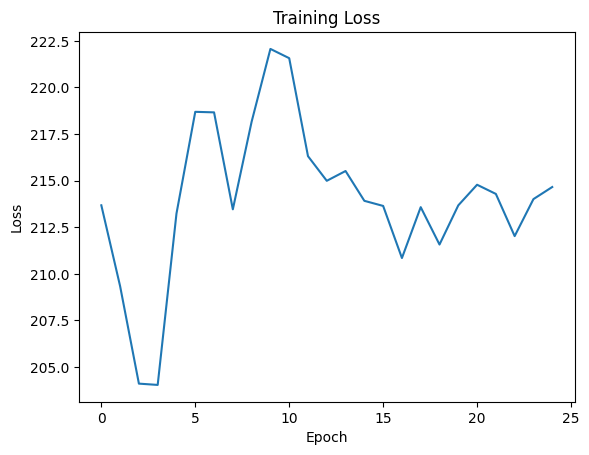

In [38]:
# Step 12: Plot training loss
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
reconstruction_losses = []
kl_divergences = []
perceptual_losses = []
adversarial_losses = []

def train(epoch, kl_anneal_factor):
    model.train()
    discriminator.train()
    train_loss = 0
    recon_loss_total = 0
    kl_div_total = 0
    percept_loss_total = 0
    adv_loss_total = 0

    for data, labels in tqdm(train_loader, desc=f'Epoch {epoch}'):
        data = data.to(device)
        labels_a, labels_b, lam = labels
        labels_a = labels_a.to(device)
        labels_b = labels_b.to(device)

        data, labels_a, labels_b, lam = mixup_data(data, labels_a)

        optimizer.zero_grad()
        with autocast():
            recon_batch, mu, logvar = model(data, labels_a)
            recon_loss = F.mse_loss(recon_batch, data, reduction='sum')
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            percept_loss_value = perceptual_loss(recon_batch, data)

            valid = torch.ones(data.size(0), device=device)
            fake = torch.zeros(data.size(0), device=device)

            real_loss = F.binary_cross_entropy_with_logits(discriminator(data), valid)
            fake_loss = F.binary_cross_entropy_with_logits(discriminator(recon_batch.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            g_loss = F.binary_cross_entropy_with_logits(discriminator(recon_batch), valid)

            loss = recon_loss + kl_anneal_factor * kl_divergence + percept_loss_value + 0.001 * g_loss

        scaler.scale(loss).backward()
        clip_grad_norm_(model.parameters(), 1.0)
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_div_total += kl_divergence.item()
        percept_loss_total += percept_loss_value.item()
        adv_loss_total += g_loss.item()

        scaler.step(optimizer)
        scaler.update()

        optimizer_d.zero_grad()
        scaler.scale(d_loss).backward()
        scaler.step(optimizer_d)
        scaler.update()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = recon_loss_total / len(train_loader.dataset)
    avg_kl_div = kl_div_total / len(train_loader.dataset)
    avg_percept_loss = percept_loss_total / len(train_loader.dataset)
    avg_adv_loss = adv_loss_total / len(train_loader.dataset)

    reconstruction_losses.append(avg_recon_loss)
    kl_divergences.append(avg_kl_div)
    perceptual_losses.append(avg_percept_loss)
    adversarial_losses.append(avg_adv_loss)

    writer.add_scalar('Loss/train', avg_loss, epoch)
    writer.add_scalar('Loss/reconstruction', avg_recon_loss, epoch)
    writer.add_scalar('Loss/kl_divergence', avg_kl_div, epoch)
    writer.add_scalar('Loss/perceptual', avg_percept_loss, epoch)
    writer.add_scalar('Loss/adversarial', avg_adv_loss, epoch)

    print(f'Epoch {epoch}, Loss: {avg_loss}')

    return avg_loss

plt.figure(figsize=(12, 8))

plt.plot(reconstruction_losses, label='Reconstruction Loss')
plt.plot(kl_divergences, label='KL Divergence')
plt.plot(perceptual_losses, label='Perceptual Loss')
plt.plot(adversarial_losses, label='Adversarial Loss')

plt.title('Training Loss Components')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


The training loss plot I'm analyzing shows a significant initial drop followed by notable fluctuations, peaking around the 5th epoch before generally trending downward and stabilizing towards the later epochs. These fluctuations suggest the model is exploring the parameter space, potentially influenced by learning rate settings or the stochastic nature of the training process. As the loss begins to stabilize around 213 to 215 in the later epochs, it indicates that the model may be nearing convergence. The presence of these fluctuations and the final plateau could also suggest a need to adjust the learning regimen, such as by modifying the learning rate or optimizing the model architecture, to smooth out the loss reduction and potentially improve model performance and generalization.

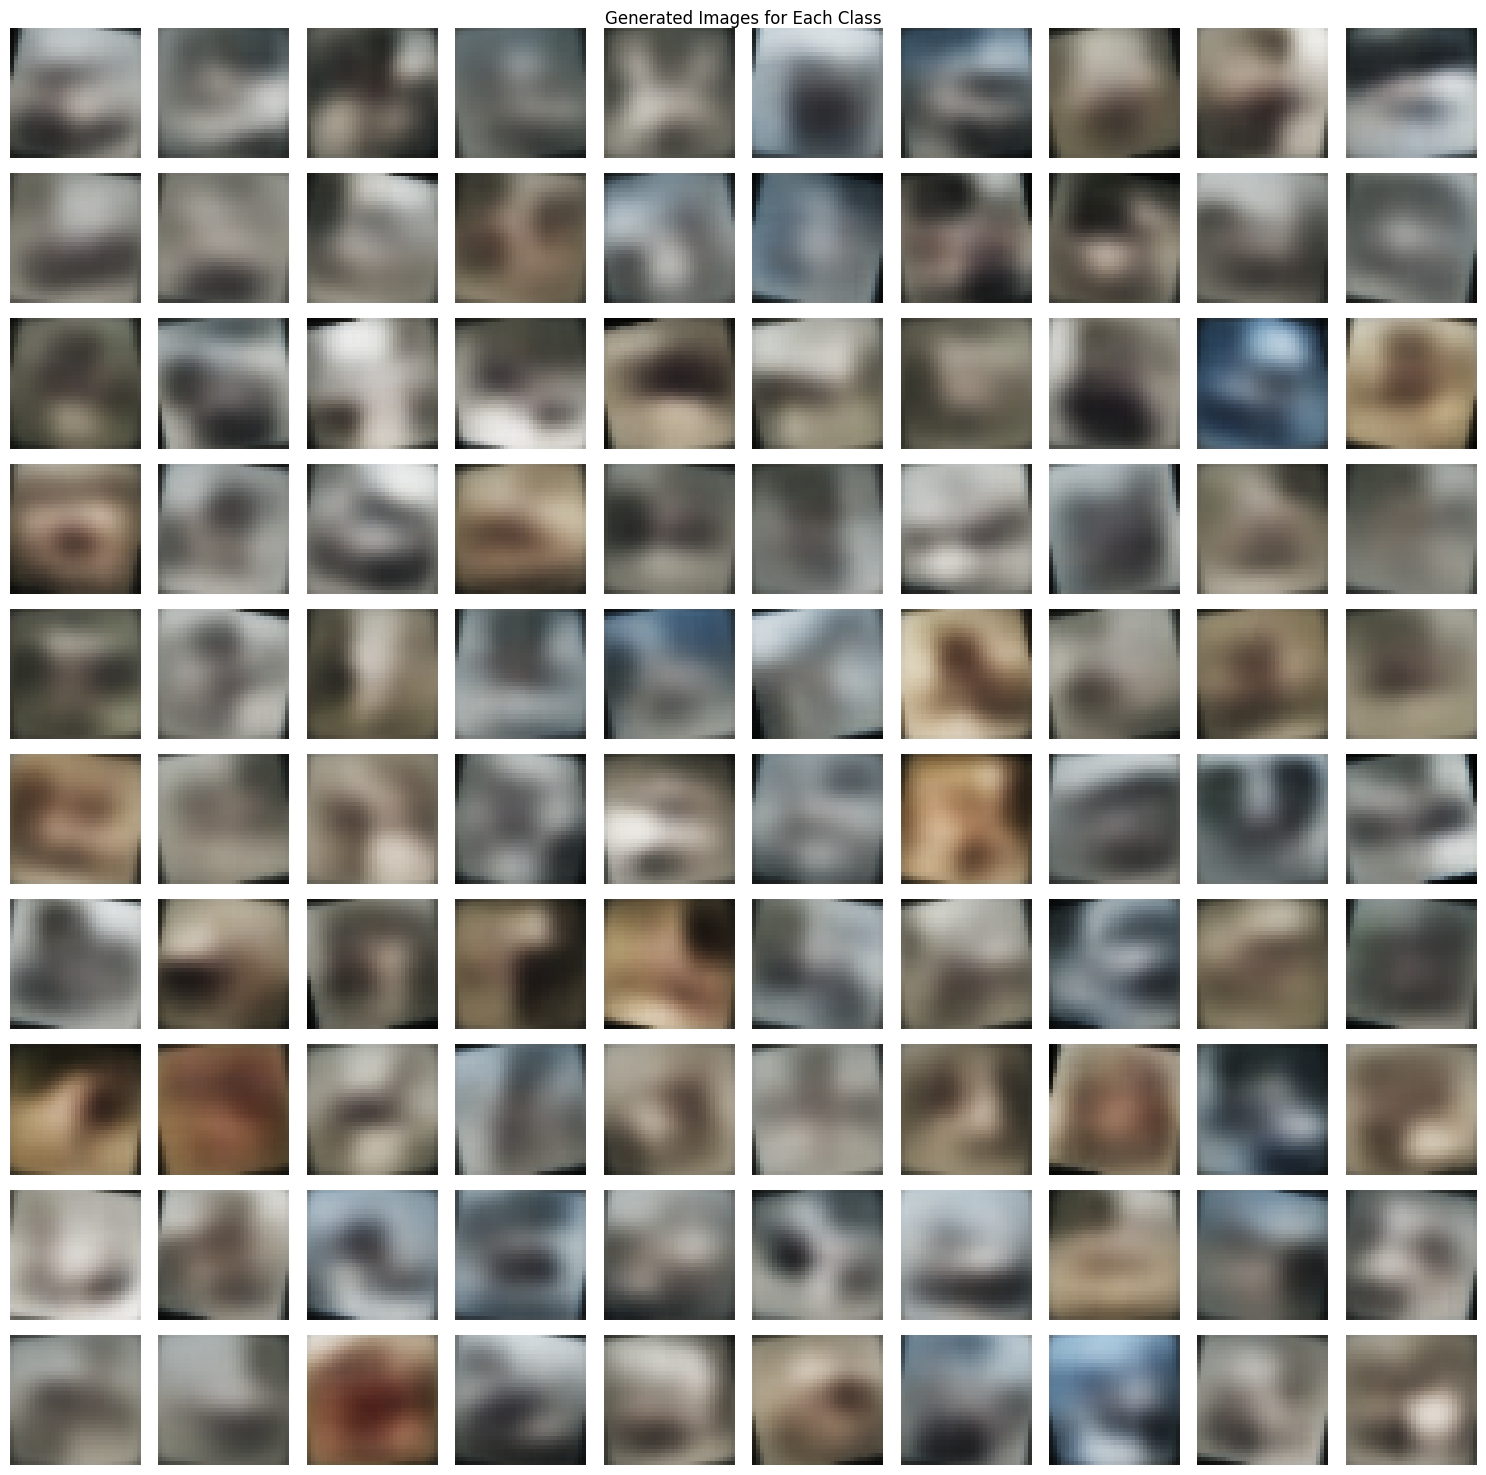

In [39]:
# Step 13: Generate and display images for each class
def generate_and_display_images(model, num_images_per_class=10):
    model.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(10, num_images_per_class, figsize=(15, 15))
        for class_label in range(10):
            labels = torch.full((num_images_per_class,), class_label, dtype=torch.long, device=device)
            z = torch.randn(num_images_per_class, model.latent_dim, device=device)
            generated_images = model.decode(z, labels).cpu()
            generated_images = (generated_images * 0.5) + 0.5  # Denormalize

            for i in range(num_images_per_class):
                img = generated_images[i].permute(1, 2, 0).numpy()
                axes[class_label, i].imshow(img)
                axes[class_label, i].axis('off')

        plt.suptitle("Generated Images for Each Class")
        plt.tight_layout()
        plt.show()

generate_and_display_images(model, num_images_per_class=10)

# Close TensorBoard writer
writer.close()

But initially, it was not like this. When I had the most basic CVAE, incorporating label conditioning to generate and reconstruct images, using data normalization, latent space sampling with the reparameterization trick, and using a combination of reconstruction loss and KL divergence for training, it looked like this with epoch 20:

![Alt Text](initial.png)

Then with some tweaking and epoch 40, it looked like this:

![Alt Text](initial2.png)

Got better actually.

And then I also tried rotating but here is a thing, I chose random rotation and did not retrieve it in initial form because it was taking a lot!

![Alt Text](initial_with_rotation.png)

But actually, in reviewing our final image, I observed that the images are somewhat blurry and lack sharp details, a common issue in CVAEs or GANs trained on complex datasets like CIFAR-10. This blurriness shows that while the model has learned to capture general color and shape features of the classes, it struggles with fine details. Each row displays a variety of colors and forms, indicating that the model has learned to generate diverse instances within a class rather than repeating identical outputs. The model appears to differentiate between classes effectively, though exact object categories are hard to discern due to the blurriness. The reasonable representation of colors and textures suggests that the model has learned the distribution of these features across the dataset. However, the overall fuzziness affects the perceived realism of the images. These observations suggest that while the model can interpret and recreate visual concepts based on class labels, there is room for improvement in image clarity and detail, potentially through further training, tuning the model's architecture, or using more advanced image generation techniques.